**Detect Nuceli in .ome File lists**

Aim : To load, threshold, and detect nuceli for futher analysis.

Try Batch Analysis of Exp0106 (which had a larger z-stack)

Updates for v1.3
    - forget tkinter
    - targeted filelist
    - slow but precise localOtsu
    - automate file naming to avoid errors
    
Still to do
    - move imports to the top
    - run a batch of 3 overnight

In [63]:
import time
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.io as io
#io.use_plugin('tifffile')
import mahotas as mh
import numpy as np
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank


In [64]:
#[1] Get targeted filelist

#path='C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/'
path='C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well04_HEK293T_eGFP-KDM5A_H483A_1-1607_1/'
#In Python 3.5 and newer use the new recursive **/ functionality:

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [65]:
filelist

[]

In [4]:
#Specify output directory
output='Output/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

**Define Image processing functions**

Having generated a list of our input files and specified an output folder, 
we now need to define the functions required by our pipeline

In [5]:
# import skimage.io as io
# io.use_plugin('tifffile')

#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        if len(im.shape)==4:
            C1 = im[0,:,:,:]     #Channel = 0
            C2 = im[1,:,:,:]     #Channel = 1            
        if len(im.shape)==3:
            frames=im.shape[0]
            C1 = im[:(frames/2),:,:]     #Channel = 0
            C2 = im[(frames/2):,:,:]     #Channel = 1
            
        else:
            print 'unexpected channel organisation'
            
        #return split Channels
        return [C1, C2]
        
    else:
        print 'this is not an ome.tif'

In [6]:
filelist[1]

'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5\\Well01_HEK293T_eGFP-KDM5A_5_MMStack_18-Pos_000_001.ome.tif'

In [7]:
filepath = filelist[1]

In [8]:
#Generate mask filenames
repl = '5_MMStack_18-Pos_000_001.ome.tif'

filename = os.path.basename(filepath) 
mask2name=filename.replace(repl,'1_Mask2')
mask4name=filename.replace(repl,'1_Mask4')
mask5name=filename.replace(repl,'1_Mask5')

#Generate save paths
mask2path = newpath+mask2name
mask4path = newpath+mask4name
mask5path = newpath+mask5name
mask5path

'C:/Users/David Brown/Documents/Huang Lab/Exp0106/Well01_HEK293T_eGFP-KDM5A_5/Output/Well01_HEK293T_eGFP-KDM5A_1_Mask5'

In [9]:
##Extract channel information for a given filepath
[GFP_stack, Hoechst_stack] = load_ome(filepath)

C:\Users\David Brown\Anaconda2\lib\site-packages\skimage\external\tifffile\tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


In [10]:
z = 18
stackname = filename.replace(repl, str('1_z'+str(z)))

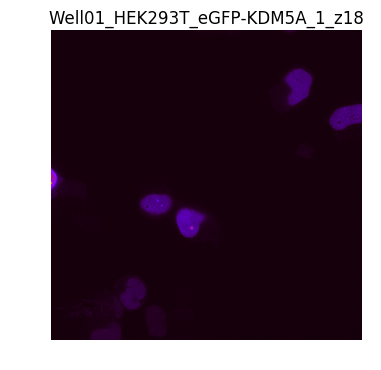

In [11]:
plt.imshow(GFP_stack[z], cmap='gnuplot')
plt.axis('off')
plt.title(stackname)

#Note uneven illumination

In [53]:
#[1] Threshold by Gloabl Mean
def meanThreshStack(stack):
    return stack > stack.mean()

In [54]:
# import mahotas as mh  #used for filtering and labeling binary regions

#[2] 3D Gaussian Filter then mean
def gaussianThreshStack(stack, gaussian_filter_size=3):
    #By default gaussian_filter_size is 3
    smoothed_stack = mh.gaussian_filter(stack, gaussian_filter_size) 
    return smoothed_stack > smoothed_stack.mean()

In [55]:
# import numpy as np
# from skimage.morphology import disk
# from skimage.filters import threshold_otsu, rank

#[4] Try local Otsu (Slow)
def localOtsuStack(stack, radius = 50):
#By default the radius is 50

    selem = disk(radius)

#Input must be a 2D array
    if len(stack.shape)>2:
        
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            local_otsu = rank.otsu(frame, selem)
            mask[z] = frame >= local_otsu
        return mask
    else:
        local_otsu = rank.otsu(stack, selem)         
        print 'Input is not a 3D stack'
        return stack >= local_otsu

In [56]:
#Call precise localOtsu
#mask4=localOtsuStack(Hoechst_stack)

In [57]:
##Threshold a 3D stack (SLOW!)
def stack2mask(stack, gaussian_filter_size=3, radius = 50):
#By default gaussian_filter_size=3 for mask 2, and radius = 50 for mask4.
    
    #Calculate gaussianThresh 'mask2'
    mask2=gaussianThreshStack(Hoechst_stack, gaussian_filter_size)
         
    #Calculate localOtsu 'mask4'
    mask4=localOtsuStack(stack, radius)

    #Remove background by intersecting with 3D gaussian filter mask
    mask5 = np.logical_and(mask2, mask4)
    
    return [mask2, mask4, mask5]    

**Generate masks**

In [ ]:
##Generate threshold masks from Hoechst stack
#Takes ~1.5h
t0=time.time()
[mask2, mask4, mask5] = stack2mask(Hoechst_stack)

##Save masks, it takes hours to run each file
np.save(mask2path, mask2)
np.save(mask4path, mask4)
np.save(mask5path, mask5)

t1=time.time()

print t1-t0

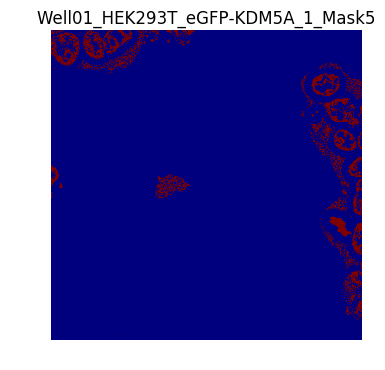

In [49]:
plt.imshow(mask5[z])
plt.axis('off')
plt.title(mask5name)